In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

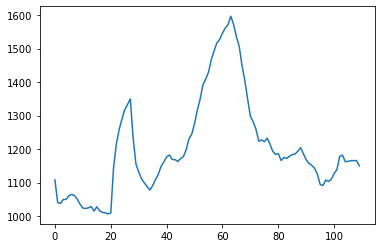

In [3]:
# Use a random dataset for testing
import pandas as pd
import matplotlib.pyplot as plt
dataframe = pd.read_csv('timeseries2.csv', usecols=[2], engine='python')
dataframe = dataframe.rolling(min_periods=1, window=7).mean().values
dataframe = pd.DataFrame(dataframe)
plt.plot(dataframe)
plt.show()

In [4]:
# Change the dataset format to float
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

73 37


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# print(trainX)

# for i in range(trainX.shape[0]):
#     print(i, trainX[i, 0], trainY[i])

In [8]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
62/62 - 3s - loss: 0.2581 - 3s/epoch - 55ms/step
Epoch 2/100
62/62 - 0s - loss: 0.1673 - 134ms/epoch - 2ms/step
Epoch 3/100
62/62 - 0s - loss: 0.1068 - 131ms/epoch - 2ms/step
Epoch 4/100
62/62 - 0s - loss: 0.0683 - 134ms/epoch - 2ms/step
Epoch 5/100
62/62 - 0s - loss: 0.0489 - 132ms/epoch - 2ms/step
Epoch 6/100
62/62 - 0s - loss: 0.0410 - 157ms/epoch - 3ms/step
Epoch 7/100
62/62 - 0s - loss: 0.0378 - 129ms/epoch - 2ms/step
Epoch 8/100
62/62 - 0s - loss: 0.0352 - 131ms/epoch - 2ms/step
Epoch 9/100
62/62 - 0s - loss: 0.0331 - 137ms/epoch - 2ms/step
Epoch 10/100
62/62 - 0s - loss: 0.0309 - 133ms/epoch - 2ms/step
Epoch 11/100
62/62 - 0s - loss: 0.0294 - 145ms/epoch - 2ms/step
Epoch 12/100
62/62 - 0s - loss: 0.0272 - 134ms/epoch - 2ms/step
Epoch 13/100
62/62 - 0s - loss: 0.0255 - 131ms/epoch - 2ms/step
Epoch 14/100
62/62 - 0s - loss: 0.0241 - 134ms/epoch - 2ms/step
Epoch 15/100
62/62 - 0s - loss: 0.0225 - 131ms/epoch - 2ms/step
Epoch 16/100
62/62 - 0s - loss: 0.0217 - 123ms/epoc

In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 25ms/step
Train Score: 25.77 RMSE
Test Score: 15.11 RMSE


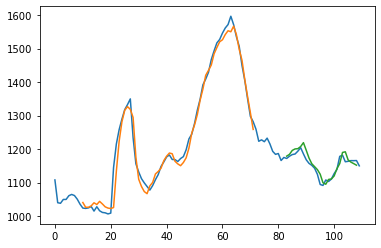

In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [12]:
data = pd.read_csv('monkeypox_daily.csv')
data = data[data['location'] == 'United States']
data = data[data['date']<='2022-09-20']
y=data['new_cases_smoothed'].to_numpy()
# X=dataframe['Count'].rolling(window=7,min_periods=1).mean().values
X=dataframe[0].to_numpy()

x_train, x_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

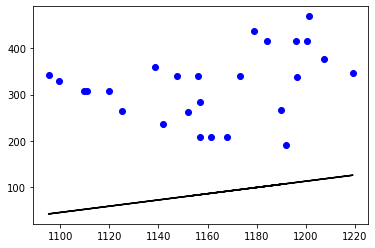

In [13]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train,y_train)
testPredict=testPredict.reshape(-1, 1)
y_pred=reg.predict(testPredict)
plt.scatter(testPredict, y_test[11:], color ='b')
plt.plot(testPredict, y_pred, color ='k')
plt.show()

In [14]:
from sklearn.metrics import r2_score
r2_score(y_test[11:],y_pred)

-9.764336976558115

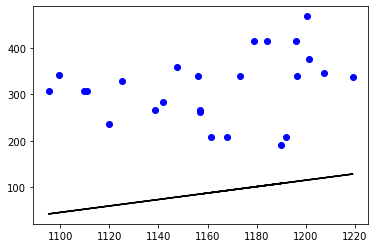

1
-9.948830914717114


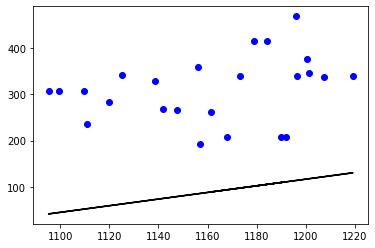

2
-9.902594625523871


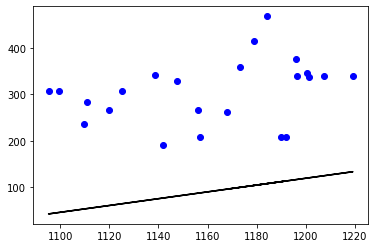

3
-9.920776649642546


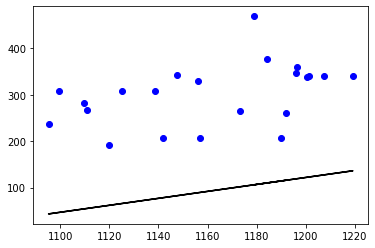

4
-9.949422626626257


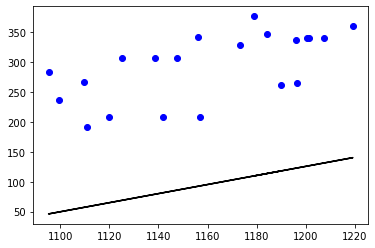

5
-12.294708328470765


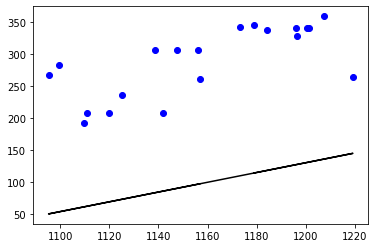

6
-12.118537392375815


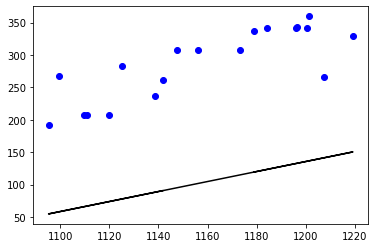

7
-11.03481145111085


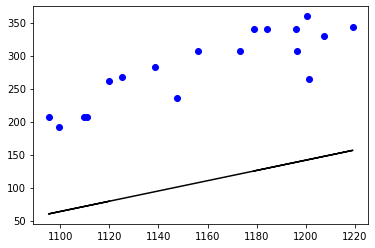

8
-9.793696645224964


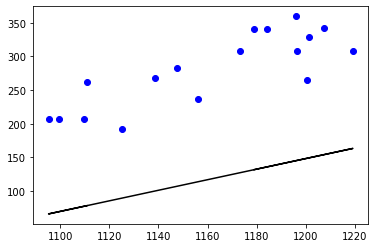

9
-8.606897768720192


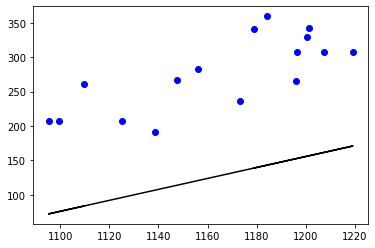

10
-7.422987132114484


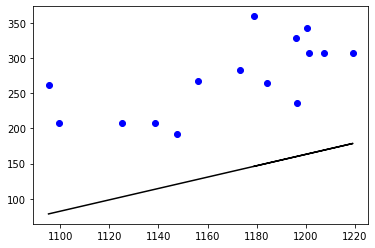

11
-6.346889484358629


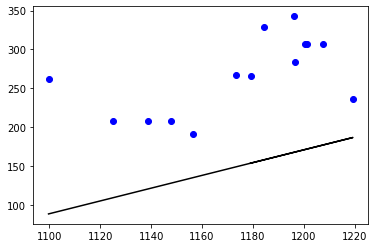

12
-5.662942374175281


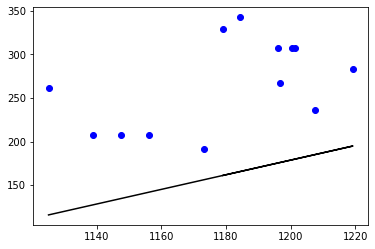

13
-4.217923542488035


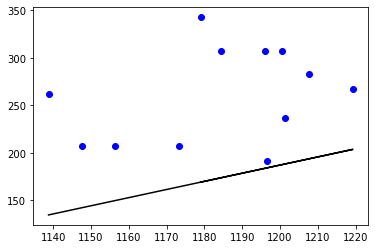

14
-3.2640467853155624


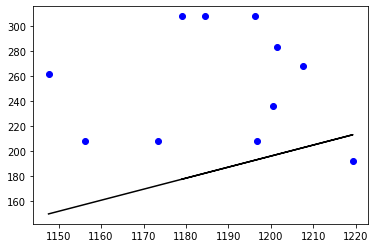

15
-2.7416988565936395


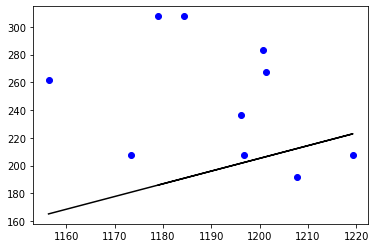

16
-1.9210691220091523


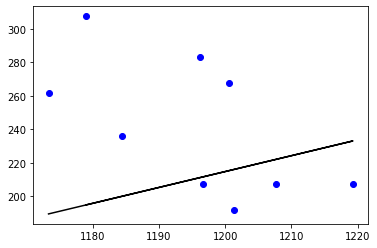

17
-1.1741481326554033


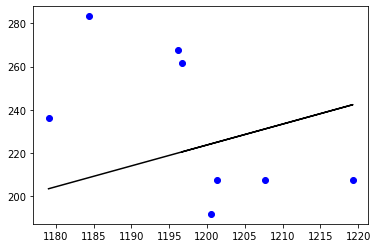

18
-0.6776804421237959


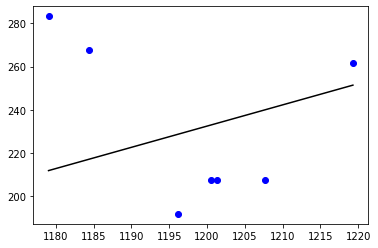

19
-0.40554344975611434


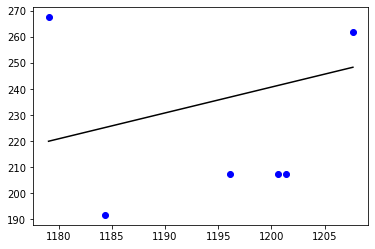

20
-0.3058172882268162


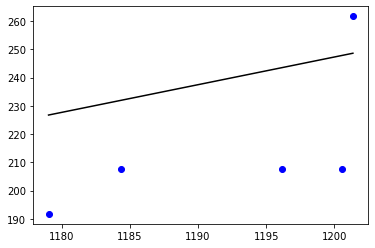

21
-0.6975294402316738


In [15]:
for i in range(1,22):
    trainX=x_train[:(len(x_train)-i)]
    trainY=y_train[i:]
    reg = LinearRegression().fit(trainX,trainY)
    testPredict=testPredict.reshape(-1, 1)
    y_pred=reg.predict(testPredict[:(len(testPredict)-i)])
    plt.scatter(testPredict[:(len(testPredict)-i)], y_test[(look_back+1+i):], color ='b')
    plt.plot(testPredict[:(len(testPredict)-i)], y_pred, color ='k')
    plt.show()
    print(i)
    print(r2_score(y_test[(look_back+1+i):],y_pred))